In [1]:
# import libraries
import sqlite3
import pandas as pd
import seaborn as sns
import scipy.stats as scs
import numpy as np
from statistics import mean, stdev
from math import sqrt
from statsmodels.stats.power import TTestIndPower, TTestPower, tt_ind_solve_power


In [2]:
data = sqlite3.connect(r'/Users/jaklynsoler/Downloads/northWind.sqlite')
c = data.cursor()
df = pd.read_sql_query("SELECT * from Product", data)
df1 = pd.read_sql_query("SELECT * from OrderDetail", data)
df2 = pd.read_sql_query("SELECT * from Supplier", data)

In [3]:
df1.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


In [4]:
def bootstrap(array):
    return np.random.choice(array, size=array.shape, replace=True)

def generate_sample_means(array, n=100):
    sample_means = []
    for i in range(n):
        sample = bootstrap(array)
        mean = np.mean(sample)
        sample_means.append(mean)
    return sample_means

In [5]:
def cohens_d(x,y):
    return (mean(x) - mean(y)) / (sqrt((stdev(x) ** 2 + stdev(y) ** 2) / 2))

# Question 1: Is there a difference in quantity of products sold by discount rate? 

In [6]:
# obtain necessary data

## {Put test name here}
H0: 

HA:

mu:0.0562 sigma:0.0835
t:0.6951 p:0.0


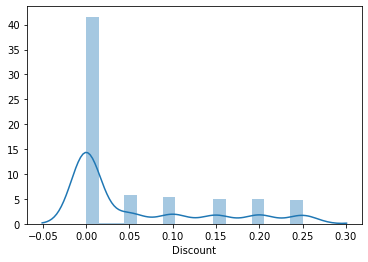

In [7]:
mu = df1['Discount'].mean()
sigma = df1['Discount'].std()
sns.distplot(df1['Discount']);
print("mu:" + str(round(mu, 4)),"sigma:" + str(round(sigma , 4)))

t, p = scs.shapiro(df1['Discount'])
print("t:" + str(round(t, 4)),"p:" + str(round(p , 4)))

# shapiro p is 0, so the data is not normal 
# need to use Central Limit Theorem to generate normal data

sample_means_discount = generate_sample_means(df1['Discount'])

mu:23.813 sigma:19.022
t:0.8515 p:0.0


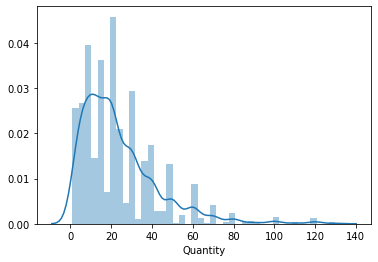

In [8]:
mu_q = df1['Quantity'].mean()
sigma_q = df1['Quantity'].std()
sns.distplot(df1['Quantity']);
print("mu:" + str(round(mu_q, 4)),"sigma:" + str(round(sigma_q , 4)))

t_q, p_q = scs.shapiro(df1['Quantity'])
print("t:" + str(round(t_q, 4)),"p:" + str(round(p_q, 4)))

# shapiro p is 0, so the data is not normal 
# need to use Central Limit Theorem to generate normal data

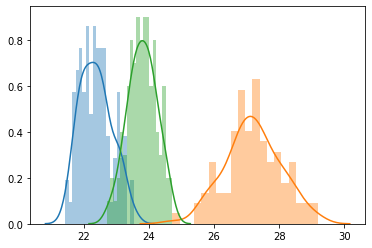

In [9]:
# separate the data into an upper and lower half by using the discount mean

df_lh_mean = df1.loc[df1['Discount'] <= df1['Discount'].mean()]
df_uh_mean = df1.loc[df1['Discount'] >= df1['Discount'].mean()]

# generate normal distributions about the upper and lower halves & full dataframe

sample_means_quantity_lower = generate_sample_means(df_lh_mean['Quantity'])
sample_means_quantity_upper = generate_sample_means(df_uh_mean['Quantity'])
sample_means_total = generate_sample_means(df1['Quantity'])

# plots all 3 distributions 

sns.distplot(sample_means_quantity_lower, label="Lower Half Sample", bins=20)
sns.distplot(sample_means_quantity_upper, label="Upper Half Sample", bins=20)
sns.distplot(sample_means_total, label="Sample", bins=20);

In [10]:
# by setting the equal variance condition to False, we specify that the function use Welch's t-test

t1, p1 = scs.ttest_ind(sample_means_quantity_lower, sample_means_quantity_upper, equal_var=False)
p1

1.2331779115160973e-96


Welch's T-Test
H0: There is no relationship between discount rate and quantity of products sold

HA: A higher discount rate will lead to a greater quantity of products sold

## Conclusion

Given p < a we can reject the null hypothesis

## EffectSize/PowerAnalysis/Tukey Testing (if needed)

In [11]:
effect_size = cohens_d(sample_means_quantity_lower, sample_means_quantity_upper)
effect_size

-6.90073278364568

In [12]:
power_analysis = tt_ind_solve_power(effect_size = effect_size,
                                    nobs1=len(sample_means_quantity_upper),
                                    alpha = 0.05)
power_analysis

1.0

# Question 2: Is there a difference in number of orders and territory? 

In [13]:
c.execute('''SELECT *
                FROM 'order'; ''')
order = pd.DataFrame(c.fetchall())
order.columns = [x[0] for x in c.description]
order.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [14]:
c.execute('''SELECT *
                FROM employee; ''')
employee = pd.DataFrame(c.fetchall())
employee.columns = [x[0] for x in c.description]
employee.head()

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,2024-08-14,908 W. Capital Way,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp
2,3,Leverling,Janet,Sales Representative,Ms.,1995-08-30,2024-04-01,722 Moss Bay Blvd.,Kirkland,North America,98033,USA,(206) 555-3412,3355,None,Janet has a BS degree in chemistry from Boston...,2.0,http://accweb/emmployees/leverling.bmp
3,4,Peacock,Margaret,Sales Representative,Mrs.,1969-09-19,2025-05-03,4110 Old Redmond Rd.,Redmond,North America,98052,USA,(206) 555-8122,5176,None,Margaret holds a BA in English literature from...,2.0,http://accweb/emmployees/peacock.bmp
4,5,Buchanan,Steven,Sales Manager,Mr.,1987-03-04,2025-10-17,14 Garrett Hill,London,British Isles,SW1 8JR,UK,(71) 555-4848,3453,None,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp


In [15]:
c.execute('''SELECT *
                FROM employeeterritory; ''')
employee_territory = pd.DataFrame(c.fetchall())
employee_territory.columns = [x[0] for x in c.description]
employee_territory.head()

,Id,EmployeeId,TerritoryId
0,1/06897,1,06897
1,1/19713,1,19713
2,2/01581,2,01581
3,2/01730,2,01730
4,2/01833,2,01833


In [16]:
c.execute('''SELECT *
                FROM territory; ''')
territory = pd.DataFrame(c.fetchall())
territory.columns = [x[0] for x in c.description]
territory.head()

,Id,TerritoryDescription,RegionId
0,01581,Westboro,1
1,01730,Bedford,1
2,01833,Georgetow,1
3,02116,Boston,1
4,02139,Cambridge,1


In [17]:
c.execute('''SELECT *
                FROM orderdetail; ''')
orderdetail = pd.DataFrame(c.fetchall())
orderdetail.columns = [x[0] for x in c.description]
orderdetail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


### The tables can be joined so that Orders can be affiliated with Territories

In [18]:
#Rename Territory's Id column to TerritoryId to match Employee Territory

territory.rename(columns={ 'Id' : 'TerritoryId'}, inplace = True)

In [19]:
#merge territory and employee territory

merge_1 = pd.merge(territory, employee_territory, on= 'TerritoryId', how = 'outer')

In [20]:
merge_1.head()

,TerritoryId,TerritoryDescription,RegionId,Id,EmployeeId
0,01581,Westboro,1,2/01581,2.0
1,01730,Bedford,1,2/01730,2.0
2,01833,Georgetow,1,2/01833,2.0
3,02116,Boston,1,2/02116,2.0
4,02139,Cambridge,1,2/02139,2.0


In [21]:
employee.head(2)

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,2024-08-14,908 W. Capital Way,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp


In [22]:
employee.rename(columns={'Id' : 'EmployeeId'}, inplace = True)

In [23]:
#merge employee
merge_2 = pd.merge(merge_1, employee, on= 'EmployeeId', how = 'outer')

In [24]:
merge_2.head(2)

,TerritoryId,TerritoryDescription,RegionId,Id,EmployeeId,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,...,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,01581,Westboro,1,2/01581,2.0,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,...,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp
1,01730,Bedford,1,2/01730,2.0,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,...,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp


In [25]:
order.head(2)

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany


In [26]:
order.rename(columns={'Id' : 'OrderId'}, inplace = True)

In [27]:
#merge order
merge_3 = pd.merge(merge_2, order, on= 'EmployeeId', how = 'outer')

In [28]:
merge_3.head(2)

,TerritoryId,TerritoryDescription,RegionId,Id,EmployeeId,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,...,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,01581,Westboro,1,2/01581,2.0,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,...,2012-08-22,2012-08-12,1.0,55.28,Blondel père et fils,"24, place Kléber",Strasbourg,Western Europe,67000,France
1,01581,Westboro,1,2/01581,2.0,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,...,2012-09-06,2012-08-13,3.0,125.77,Morgenstern Gesundkost,Heerstr. 22,Leipzig,Western Europe,04179,Germany


In [29]:
order.head()

,OrderId,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [30]:
orderdetail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [31]:
#merge order detail
merge_4 = pd.merge(merge_3, orderdetail, on= 'OrderId', how = 'outer')

In [32]:
merge_4.head()

,TerritoryId,TerritoryDescription,RegionId,Id_x,EmployeeId,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,...,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Id_y,ProductId,UnitPrice,Quantity,Discount
0,01581,Westboro,1,2/01581,2.0,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,...,"24, place Kléber",Strasbourg,Western Europe,67000,France,10265/17,17.0,31.2,30.0,0.0
1,01581,Westboro,1,2/01581,2.0,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,...,"24, place Kléber",Strasbourg,Western Europe,67000,France,10265/70,70.0,12.0,20.0,0.0
2,01730,Bedford,1,2/01730,2.0,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,...,"24, place Kléber",Strasbourg,Western Europe,67000,France,10265/17,17.0,31.2,30.0,0.0
3,01730,Bedford,1,2/01730,2.0,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,...,"24, place Kléber",Strasbourg,Western Europe,67000,France,10265/70,70.0,12.0,20.0,0.0
4,01833,Georgetow,1,2/01833,2.0,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,...,"24, place Kléber",Strasbourg,Western Europe,67000,France,10265/17,17.0,31.2,30.0,0.0


In [57]:
region_count_df = merge_4[['RegionId','OrderId', 'ShipRegion']]

In [58]:
region_count_df.head()

,RegionId,OrderId,ShipRegion
0,1,10265.0,Western Europe
1,1,10265.0,Western Europe
2,1,10265.0,Western Europe
3,1,10265.0,Western Europe
4,1,10265.0,Western Europe


In [77]:
orders_by_region = region_count_df.groupby('RegionId').OrderId.mean()

In [78]:
orders_by_region.head()

RegionId
1    10664.421230
2    10654.967308
3    10678.438793
4    10658.838006
Name: OrderId, dtype: float64

In [79]:
regional_orders_df = orders_by_region.to_frame(name = 'Total Orders')

In [80]:
regional_orders_df.head()

,Total Orders
RegionId,
1,10664.421230
2,10654.967308
3,10678.438793
4,10658.838006


In [81]:
regional_orders_df.reset_index(inplace = True)

In [82]:
regional_orders_df[0:20]

,RegionId,Total Orders
0,1,10664.421230
1,2,10654.967308
2,3,10678.438793
3,4,10658.838006


In [83]:
regional_orders_df['Percent of Total'] = regional_orders_df['Total Orders'] / regional_orders_df['Total Orders'].sum() * 100

In [84]:
regional_orders_df.head()

,RegionId,Total Orders,Percent of Total
0,1,10664.421230,25.000598
1,2,10654.967308,24.978435
2,3,10678.438793,25.033459
3,4,10658.838006,24.987509


In [85]:
#compare regions as different populations?

#mean of means for normal distribution

#list order prices --> avg orders
#predict significant region by sampling?

#mean of orders from a region

In [89]:
order.head()

,OrderId,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [90]:
# if you wanted to check order quantity by region
orderdetail['total_unit_price'] = orderdetail['UnitPrice'] * orderdetail['Quantity']
orderdetail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,total_unit_price
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


In [105]:
od_group = orderdetail.groupby(by = 'OrderId')['total_unit_price'].agg(sum)
od_group.head()

OrderId
10248     440.0
10249    1863.4
10250    1813.0
10251     670.8
10252    3730.0
Name: total_unit_price, dtype: float64

In [111]:
order['total_price'] = order['OrderId'].apply(lambda x: od_group[x])
order.median()

OrderId        10662.50
EmployeeId         4.00
ShipVia            2.00
Freight           41.36
total_price     1015.90
dtype: float64

In [115]:
order.OrderId.describe()

count      830.000000
mean     10662.500000
std        239.744656
min      10248.000000
25%      10455.250000
50%      10662.500000
75%      10869.750000
max      11077.000000
Name: OrderId, dtype: float64

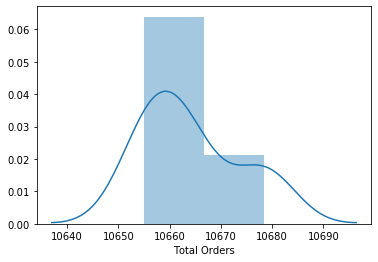

In [86]:
sns.distplot(regional_orders_df['Total Orders']);

/Users/jaklynsoler/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


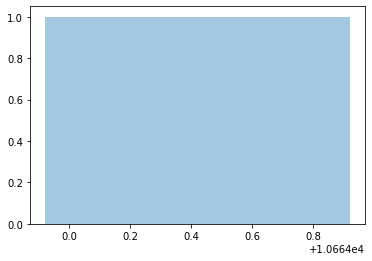

In [87]:
sns.distplot(regional_orders_df['Total Orders'][0]);

In [ ]:
sns.distplot(regional_orders_df['Total Orders']);

In [ ]:
sns.distplot(regional_orders_df['Total Orders']);

In [ ]:
sns.distplot(regional_orders_df['Total Orders']);

## {Put test name here}
H0: 

HA:

In [ ]:
# perform test

## Conclusion

# Question 3: {You decide}

In [ ]:
# obtain necessary data

## {Put test name here}
H0: 

HA:

In [ ]:
# perform test

## Conclusion

## EffectSize/PowerAnalysis/Tukey Testing (if needed)